In [4]:
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, classification_report, confusion_matrix
import utils as ut
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import warnings

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [5]:
df = pd.read_csv('data/balanced_data.csv')
df = df.drop(columns=['Unnamed: 0'])

In [6]:
# # Разделяем датасет на X, y
X, y = ut.split_to_x_y(df, 'class')

In [7]:
X.columns

Index(['message', 'date', 'photo', 'name', 'old', 'distance_to', 'height',
       'romantic_relationships', 'fwb_ons', 'not_looking_for', 'inst',
       'cringe_phrase', 'similar_interests', 'clean_text', 'is_empty',
       'message_len', 'sum'],
      dtype='object')

In [8]:
# Удалим ненужные столбцы:
columns_to_drop = ["message", "date", "photo", 'clean_text', 'inst', 'distance_to', 'fwb_ons', 'name']
X.drop(columns=columns_to_drop, inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## RandomForest & XGBoost

In [10]:
# Данные для тюнинга
eval_data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
max_evals = 25
metric = roc_auc_score  # f1_score, roc_auc_score, accuracy_score, recall_score

is_tuning = False
is_save = False
save_name = ''
load_name = '_best'
cv = 3
__spec__ = None
rf_model, rf_pred, xgb_model, xgb_pred = ut.tuning(is_tuning, eval_data, metric, max_evals, save_name, load_name)

## kNN:

In [11]:
if is_tuning:
    test_score = {}
    n_neighbors = np.arange(2, 30, 1)
    for neighbor in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=neighbor)
        knn.fit(X_train, y_train.values.ravel())
        test_score[neighbor] = metric(y_true=y_test, y_score=knn.predict(X_test))

    for key, value in test_score.items():
        if value==max(test_score.values()):
            n_best = key
            print('n_best:', n_best)

    knn = KNeighborsClassifier(n_neighbors=n_best)
    knn.fit(X_train, y_train.values.ravel())
    ut.save_model(knn, f'./models/knn{save_name}.pkl')
else:
    knn = ut.load_model(f'./models/knn{load_name}.pkl')


In [12]:
knn_pred = knn.predict(X_test)

## AdaBoostClassifier

In [13]:
if is_tuning:
    adaboost = AdaBoostClassifier(random_state=42)

    parameters = {
        'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
        'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
        'algorithm': ['SAMME', 'SAMME.R']
    }
    clf = GridSearchCV(adaboost, parameters, cv=5)
    clf.fit(X_train, y_train.values.ravel())
    adb_model = clf.best_estimator_
    ut.save_model(adb_model, f'./models/adaboost{save_name}.pkl')
else:
    adb_model = ut.load_model(f'./models/adaboost{load_name}.pkl')

adb_pred = adb_model.predict(X_test)

## BernoulliNB

In [14]:
from sklearn.naive_bayes import BernoulliNB

if is_tuning:
    params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
              'fit_prior': [True, False],
              'class_prior': [None, [0.1,] * 2],
              'binarize': [None, 0.0, 8.5, 10.0]
              }

    clf = GridSearchCV(BernoulliNB(), param_grid=params, cv=5)
    clf.fit(X_train, y_train.values.ravel())

    BNB = clf.best_estimator_
    ut.save_model(BNB, f'./models/naive_bayes{save_name}.pkl')
else:
    BNB = ut.load_model(f'./models/naive_bayes{load_name}.pkl')

bnb_pred = BNB.predict(X_test)

**Метрики на сбалансированном датасете:**

In [15]:
print('BernoulliNB\n', classification_report(y_pred=bnb_pred, y_true=y_test))
cv_score = cross_val_score(BNB, X_test, y_test.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=bnb_pred, y_true=y_test), 'CV_SCORE:', cv_score.mean(), cv_score)

BernoulliNB
               precision    recall  f1-score   support

         0.0       0.71      0.95      0.81       439
         1.0       0.95      0.70      0.80       565

    accuracy                           0.81      1004
   macro avg       0.83      0.82      0.81      1004
weighted avg       0.84      0.81      0.81      1004

ROC_AUC_SCORE: 0.8247545709274902 CV_SCORE: 0.8077844311377246 [0.79104478 0.80895522 0.82335329]


In [16]:
print('KNNClassifier\n', classification_report(y_pred=knn_pred, y_true=y_test))
cv_score = cross_val_score(knn, X_test, y_test.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=knn_pred, y_true=y_test), 'CV_SCORE:', cv_score.mean(), cv_score)

KNNClassifier
               precision    recall  f1-score   support

         0.0       0.73      0.91      0.81       439
         1.0       0.91      0.74      0.82       565

    accuracy                           0.81      1004
   macro avg       0.82      0.82      0.81      1004
weighted avg       0.83      0.81      0.82      1004

ROC_AUC_SCORE: 0.8249843772048299 CV_SCORE: 0.7769148270622933 [0.77014925 0.76119403 0.7994012 ]


In [17]:
print('AdaBoostClassifier\n', classification_report(y_pred=adb_pred, y_true=y_test))
cv_score = cross_val_score(adb_model, X_test, y_test.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=adb_pred, y_true=y_test), 'CV_SCORE:', cv_score.mean(), cv_score)



AdaBoostClassifier
               precision    recall  f1-score   support

         0.0       0.78      1.00      0.88       439
         1.0       1.00      0.78      0.88       565

    accuracy                           0.88      1004
   macro avg       0.89      0.89      0.88      1004
weighted avg       0.90      0.88      0.88      1004

ROC_AUC_SCORE: 0.8893805309734513 CV_SCORE: 0.8755027258915006 [0.87164179 0.87462687 0.88023952]


In [18]:
print('RandomForestClassifier\n', classification_report(y_pred=rf_pred, y_true=y_test))
cv_score = cross_val_score(rf_model, X_test, y_test.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=rf_pred, y_true=y_test), 'CV_SCORE:', cv_score.mean(), cv_score)


RandomForestClassifier
               precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       439
         1.0       0.90      0.93      0.91       565

    accuracy                           0.90      1004
   macro avg       0.90      0.90      0.90      1004
weighted avg       0.90      0.90      0.90      1004

ROC_AUC_SCORE: 0.8962646400709577 CV_SCORE: 0.8794858045103822 [0.86865672 0.88656716 0.88323353]


In [19]:
print('XGBoostClassifier\n', classification_report(y_pred=xgb_pred, y_true=y_test))
cv_score = cross_val_score(xgb_model, X_test, y_test.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=xgb_pred, y_true=y_test), 'CV_SCORE:', cv_score.mean(), cv_score)

XGBoostClassifier
               precision    recall  f1-score   support

         0.0       0.90      0.86      0.88       439
         1.0       0.90      0.93      0.91       565

    accuracy                           0.90      1004
   macro avg       0.90      0.90      0.90      1004
weighted avg       0.90      0.90      0.90      1004

ROC_AUC_SCORE: 0.8962646400709577 CV_SCORE: 0.8217386123275836 [0.80298507 0.81492537 0.84730539]


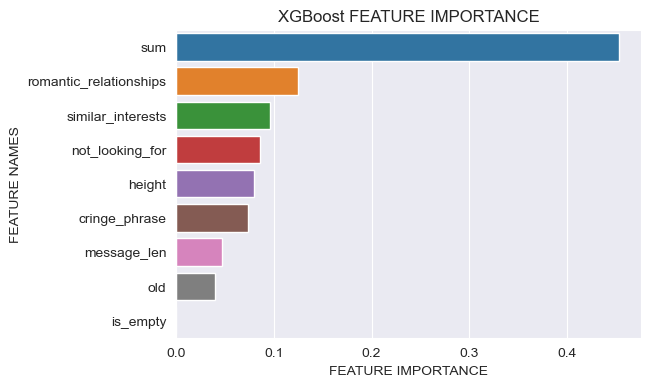

In [20]:
ut.plot_feature_importance(xgb_model.feature_importances_,X_train.columns,'XGBoost')
if is_save:
    plt.savefig('./img/XGB.png', bbox_inches="tight")

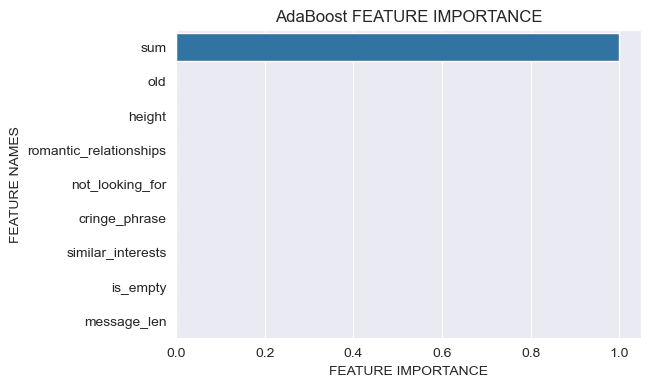

In [21]:
ut.plot_feature_importance(adb_model.feature_importances_,X_train.columns,'AdaBoost')
if is_save:
    plt.savefig('./img/ADB.png', bbox_inches="tight")

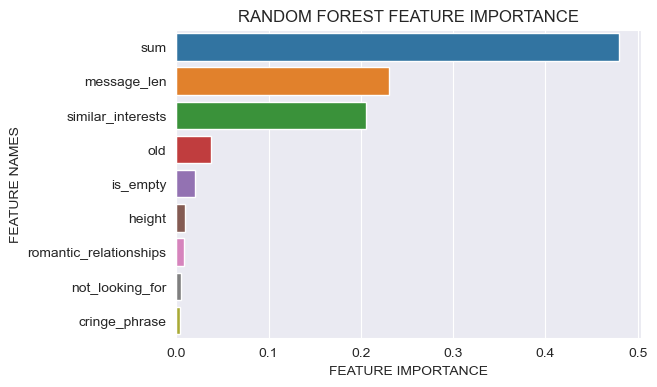

In [22]:
ut.plot_feature_importance(rf_model.feature_importances_,X_train.columns,'RANDOM FOREST')
if is_save:
    plt.savefig('./img/RF.png', bbox_inches="tight")


## Протестируем модель на "реальном эксперименте, а именно:
- были пролайканы несколько анкет (n штук) в режиме реального времени
- будет применена модель для сравнения с "реальной" ситуацией

In [23]:
df_real = pd.read_csv('data/test_data.csv')
df_real = df_real.drop(columns=['Unnamed: 0'])

# # Разделяем датасет на X, y
X_real, y_real = ut.split_to_x_y(df_real, 'class')

In [24]:
X_real.columns

Index(['message', 'date', 'photo', 'name', 'old', 'distance_to', 'height',
       'romantic_relationships', 'fwb_ons', 'not_looking_for', 'inst',
       'cringe_phrase', 'similar_interests', 'clean_text', 'is_empty',
       'message_len', 'sum'],
      dtype='object')

In [25]:
columns_to_drop_real = columns_to_drop
X_real.drop(columns=columns_to_drop_real, inplace=True)

**Метрики теста на "реальном" датасете:**

In [26]:
print('BernoulliNB:\n', classification_report(y_pred=BNB.predict(X_real), y_true=y_real))
cv_score = cross_val_score(BNB, X_real, y_real.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=BNB.predict(X_real), y_true=y_real), 'CV_SCORE:', cv_score.mean(), cv_score)

BernoulliNB:
               precision    recall  f1-score   support

         0.0       0.73      0.12      0.21       223
         1.0       0.10      0.69      0.18        32

    accuracy                           0.19       255
   macro avg       0.42      0.40      0.19       255
weighted avg       0.65      0.19      0.20       255

ROC_AUC_SCORE: 0.40428811659192826 CV_SCORE: 0.8745098039215686 [0.88235294 0.87058824 0.87058824]


In [27]:
print('KNNClassifier:\n', classification_report(y_pred=knn.predict(X_real), y_true=y_real))
cv_score = cross_val_score(knn, X_real, y_real.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=knn.predict(X_real), y_true=y_real), 'CV_SCORE:', cv_score.mean(), cv_score)

KNNClassifier:
               precision    recall  f1-score   support

         0.0       0.79      0.17      0.27       223
         1.0       0.11      0.69      0.18        32

    accuracy                           0.23       255
   macro avg       0.45      0.43      0.23       255
weighted avg       0.70      0.23      0.26       255

ROC_AUC_SCORE: 0.4267096412556054 CV_SCORE: 0.8745098039215686 [0.88235294 0.87058824 0.87058824]


In [28]:
print('AdaBoostClassifier:\n', classification_report(y_pred=adb_model.predict(X_real), y_true=y_real))
cv_score = cross_val_score(adb_model, X_real, y_real.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=adb_model.predict(X_real), y_true=y_real), 'CV_SCORE:', cv_score.mean(), cv_score)

AdaBoostClassifier:
               precision    recall  f1-score   support

         0.0       0.89      0.52      0.65       223
         1.0       0.14      0.56      0.23        32

    accuracy                           0.52       255
   macro avg       0.52      0.54      0.44       255
weighted avg       0.80      0.52      0.60       255

ROC_AUC_SCORE: 0.539097533632287 CV_SCORE: 0.8745098039215686 [0.88235294 0.87058824 0.87058824]


In [29]:
print('RandomForestClassifier:\n', classification_report(y_pred=rf_model.predict(X_real.values), y_true=y_real))
cv_score = cross_val_score(rf_model, X_real, y_real.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=rf_model.predict(X_real), y_true=y_real), 'CV_SCORE:', cv_score.mean(), cv_score)

RandomForestClassifier:
               precision    recall  f1-score   support

         0.0       0.89      0.51      0.65       223
         1.0       0.14      0.56      0.23        32

    accuracy                           0.52       255
   macro avg       0.52      0.54      0.44       255
weighted avg       0.80      0.52      0.60       255

ROC_AUC_SCORE: 0.5368553811659192 CV_SCORE: 0.8705882352941177 [0.88235294 0.87058824 0.85882353]


In [30]:
print('XGBoostClassifier:\n', classification_report(y_pred=xgb_model.predict(X_real.values), y_true=y_real))
cv_score = cross_val_score(xgb_model, X_real, y_real.values.ravel(), cv=cv)
print('ROC_AUC_SCORE:', roc_auc_score(y_score=xgb_model.predict(X_real), y_true=y_real), 'CV_SCORE:', cv_score.mean(), cv_score)

XGBoostClassifier:
               precision    recall  f1-score   support

         0.0       0.84      0.22      0.35       223
         1.0       0.12      0.72      0.20        32

    accuracy                           0.28       255
   macro avg       0.48      0.47      0.27       255
weighted avg       0.75      0.28      0.33       255

ROC_AUC_SCORE: 0.4692404708520179 CV_SCORE: 0.823529411764706 [0.84705882 0.83529412 0.78823529]


Confusion matrix, without normalization
[[114 109]
 [ 14  18]]


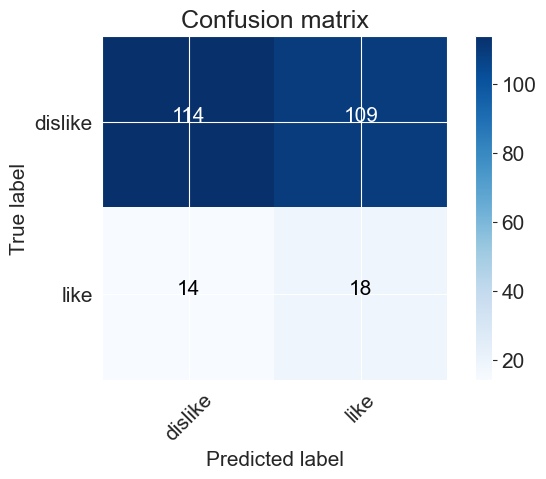

In [31]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_real, rf_model.predict(X_real.values))
ut.plot_confusion_matrix(cnf_matrix, classes=['dislike', 'like'],
                      title='Confusion matrix')
if is_save:
    plt.savefig('./img/c_matrix.png')

In [32]:
# pred = pd.Series(xgb_model.predict(X_real.values))
# pred.value_counts()

In [33]:
# X_real['y_pred'] = pred
# X_real['y_true'] = y_real.astype('int')

In [34]:
# X_real